In [1]:
import pandas as pd
import mysql.connector as sql
import seaborn as sns
import numpy as np
from rdkit.Chem.Draw import MolsToGridImage
from rdkit import Chem
from ipywidgets import interact
import math

RDKit WARNING: [19:59:08] Enabling RDKit 2019.09.3 jupyter extensions


The next three cells reqire a connection to a local version of the ChEMBL database.  If you don't have a local version of ChEMBL, you can skip the next three cells and load the csv file with data below. 

In [2]:
hostname = 'localhost'
database = 'chembl_27'
user = 'pwalters'
password = 'imnottellin'
con = sql.connect(host=hostname, database=database, user=user, password=password)

In [3]:
query = """select cs.canonical_smiles, cs.molregno, usan_tbl.synonyms, act.assay_id, act.standard_value, act.standard_type, act.standard_units from activities act
    join compound_structures cs on cs.molregno = act.molregno
    join assays a on act.assay_id = a.assay_id
    join source s on a.src_id = s.src_id
    left join (select molregno, synonyms from molecule_synonyms where syn_type = 'USAN') as usan_tbl on usan_tbl.molregno = cs.molregno
    where src_description = 'SARS-CoV-2 Screening Data'"""

In [4]:
df = pd.read_sql(query,con=con)

If you don't have a local version of the ChEMBL database, just load the data from a csv file.  Skip the cell below if you executed the database query above. 

In [5]:
df = pd.read_csv("ChEMBL_SARS-Cov-2_Screening.csv")

See how many rows we have retrieved

In [6]:
df.shape

(9785, 7)

Take a look at the dataframe

In [7]:
df

,canonical_smiles,molregno,synonyms,assay_id,standard_value,standard_type,standard_units
0,O=C(O)c1ccc(N2C(=O)/C(=C/c3ccc(-c4ccc([N+](=O)...,1033892,NaN,1804482,8.709636e+06,IC50,nM
1,O=C(O)/C(Cc1ccccc1[N+](=O)[O-])=N\Nc1nc(-c2ccc...,425006,NaN,1804482,2.089300e+03,IC50,nM
2,CCNC(=O)c1cc2c(-c3cc(C(C)(C)O)ccc3Oc3c(C)cc(F)...,2335425,NaN,1804482,3.467368e+06,IC50,nM
3,CCC(=O)CCCCC[C@@H]1NC(=O)[C@H]2CCCCN2C(=O)[C@H...,275631,NaN,1804482,9.996846e+08,IC50,nM
4,C[C@@H](C1CCCCC1)n1c(-c2cc3c(cc2Br)OCO3)nc2cc(...,2260454,NaN,1804482,6.025600e+02,IC50,nM
...,...,...,...,...,...,...,...
9780,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12.O=P(O)(O)O,270724,NaN,1804587,1.300000e+06,Viral titer,PFU.mL-1
9781,CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21.Cl,550303,Chlorpromazine HCl,1804587,1.100000e+06,Viral titer,PFU.mL-1
9782,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12.O=P(O)(O)O,270724,NaN,1804587,1.400000e+06,Viral titer,PFU.mL-1
9783,CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21.Cl,550303,Chlorpromazine HCl,1804587,1.100000e+06,Viral titer,PFU.mL-1


Fill in molregno where synonyms is null

In [35]:
df.synonyms = df.synonyms.fillna(df.molregno)
df.synonyms = [str(x) for x in df.synonyms]

Check the dataframe again, wow, that's cool!

In [36]:
df

,canonical_smiles,molregno,synonyms,assay_id,standard_value,standard_type,standard_units
0,O=C(O)c1ccc(N2C(=O)/C(=C/c3ccc(-c4ccc([N+](=O)...,1033892,1033892,1804482,8.709636e+06,IC50,nM
1,O=C(O)/C(Cc1ccccc1[N+](=O)[O-])=N\Nc1nc(-c2ccc...,425006,425006,1804482,2.089300e+03,IC50,nM
2,CCNC(=O)c1cc2c(-c3cc(C(C)(C)O)ccc3Oc3c(C)cc(F)...,2335425,2335425,1804482,3.467368e+06,IC50,nM
3,CCC(=O)CCCCC[C@@H]1NC(=O)[C@H]2CCCCN2C(=O)[C@H...,275631,275631,1804482,9.996846e+08,IC50,nM
4,C[C@@H](C1CCCCC1)n1c(-c2cc3c(cc2Br)OCO3)nc2cc(...,2260454,2260454,1804482,6.025600e+02,IC50,nM
...,...,...,...,...,...,...,...
9780,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12.O=P(O)(O)O,270724,270724,1804587,1.300000e+06,Viral titer,PFU.mL-1
9781,CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21.Cl,550303,Chlorpromazine HCl,1804587,1.100000e+06,Viral titer,PFU.mL-1
9782,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12.O=P(O)(O)O,270724,270724,1804587,1.400000e+06,Viral titer,PFU.mL-1
9783,CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21.Cl,550303,Chlorpromazine HCl,1804587,1.100000e+06,Viral titer,PFU.mL-1


How many unique molecules are in the dataset? 

In [37]:
len(df.molregno.unique())

6843

How many unique units are in the dataset? 

In [38]:
df.standard_units.value_counts()

%           5649
nM           466
uM            12
PFU.mL-1       7
Name: standard_units, dtype: int64

Limit our analysis to data where the units are nM

In [39]:
df_nM = df.query("standard_units == 'nM'")

How many records are in df_nM

In [40]:
df_nM.shape

(466, 7)

How many different datatypes are in df_nM

In [41]:
df_nM.standard_type.value_counts()

IC50    204
CC50    165
Ki       59
EC50     35
IC90      3
Name: standard_type, dtype: int64

Many times does each molecule appear in df_nM

In [42]:
df_nM.molregno.value_counts()

429737     13
6579       13
80081      13
2228183    12
469763     12
           ..
230659      1
2335425     1
675012      1
1047410     1
1566719     1
Name: molregno, Length: 213, dtype: int64

How many datapoints do we have for each assay

In [43]:
df_nM.assay_id.value_counts()

1804559    67
1804560    67
1804482    56
1804566    47
1804565    47
1804580    20
1804577    20
1804568    18
1804576    17
1804579    17
1804573    17
1804574    11
1804490     7
1804491     7
1804492     5
1804485     5
1804487     5
1804551     5
1804493     5
1804550     5
1804552     5
1804553     5
1804555     5
1804554     3
Name: assay_id, dtype: int64

Take a look at df_nM

In [44]:
df_nM

,canonical_smiles,molregno,synonyms,assay_id,standard_value,standard_type,standard_units
0,O=C(O)c1ccc(N2C(=O)/C(=C/c3ccc(-c4ccc([N+](=O)...,1033892,1033892,1804482,8.709636e+06,IC50,nM
1,O=C(O)/C(Cc1ccccc1[N+](=O)[O-])=N\Nc1nc(-c2ccc...,425006,425006,1804482,2.089300e+03,IC50,nM
2,CCNC(=O)c1cc2c(-c3cc(C(C)(C)O)ccc3Oc3c(C)cc(F)...,2335425,2335425,1804482,3.467368e+06,IC50,nM
3,CCC(=O)CCCCC[C@@H]1NC(=O)[C@H]2CCCCN2C(=O)[C@H...,275631,275631,1804482,9.996846e+08,IC50,nM
4,C[C@@H](C1CCCCC1)n1c(-c2cc3c(cc2Br)OCO3)nc2cc(...,2260454,2260454,1804482,6.025600e+02,IC50,nM
...,...,...,...,...,...,...,...
9735,CC/C(=C(\c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1....,47340,Tamoxifen citrate,1804580,3.796000e+04,CC50,nM
9736,CC(C)N1CCN(c2ccc(OC[C@H]3CO[C@](Cn4cncn4)(c4cc...,259959,Terconazole,1804580,4.146000e+04,CC50,nM
9737,CCSc1ccc2c(c1)N(CCCN1CCN(C)CC1)c1ccccc1S2.O=C(...,2197349,Thiethylperazine Maleate,1804580,1.837000e+04,CC50,nM
9738,CN(C)CCOc1ccc(/C(=C(/CCCl)c2ccccc2)c2ccccc2)cc...,674626,Toremifene Citrate,1804580,2.051000e+04,CC50,nM


Look at synonyms

In [45]:
df_nM.synonyms.dropna()

0                        1033892
1                         425006
2                        2335425
3                         275631
4                        2260454
                  ...           
9735           Tamoxifen citrate
9736                 Terconazole
9737    Thiethylperazine Maleate
9738          Toremifene Citrate
9739                      316600
Name: synonyms, Length: 466, dtype: object

In [46]:
unique_list = []
grouping_cols = ["canonical_smiles","molregno","synonyms","assay_id","standard_type"]
for k,v in df_nM.groupby(grouping_cols):
    val = v.standard_value.mean()
    unique_list.append(list(k)+[-np.log10(val*1e-9)])
unique_df = pd.DataFrame(unique_list,columns=grouping_cols+["pX50"])

In [47]:
unique_df

,canonical_smiles,molregno,synonyms,assay_id,standard_type,pX50
0,C/C(=N/Nc1nnc2c(n1)[nH]c1c(C)cccc12)c1ccccn1,1369075,1369075,1804559,IC50,6.619789
1,C/C(=N/Nc1nnc2c(n1)[nH]c1c(C)cccc12)c1ccccn1,1369075,1369075,1804560,CC50,7.221849
2,C/C(=N\NC(=S)N1CCC1)c1ccccn1,1297777,1297777,1804559,IC50,7.698970
3,C/C(=N\NC(=S)N1CCC1)c1ccccn1,1297777,1297777,1804560,CC50,7.698970
4,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,72873,Cyclosporine,1804565,IC50,5.235077
...,...,...,...,...,...,...
455,S=C(NCc1ccc2c(c1)OCO2)N1CCN(c2ncnc3c2oc2ccccc2...,1376121,Amuvatinib,1804559,IC50,7.698970
456,S=C(NCc1ccc2c(c1)OCO2)N1CCN(c2ncnc3c2oc2ccccc2...,1376121,Amuvatinib,1804560,CC50,7.221849
457,c1ccc(CNc2nc(NCc3ccccc3)c3ccccc3n2)cc1,1047410,1047410,1804482,IC50,5.670000
458,c1ccc2c(c1)Sc1ccccc1N2CC1CN2CCC1CC2,112175,112175,1804565,IC50,5.137869


In [48]:
pivot_df = unique_df.pivot(index='synonyms',columns="assay_id",values="pX50")
pivot_df['num_null'] = pivot_df.isnull().sum(axis=1).values
pivot_df.sort_values("num_null",inplace=True)
pivot_df.drop('num_null', axis=1, inplace=True)

In [49]:
pivot_df.head()

assay_id,1804482,1804485,1804487,1804490,1804491,1804492,1804493,1804550,1804551,1804552,...,1804560,1804565,1804566,1804568,1804573,1804574,1804576,1804577,1804579,1804580
synonyms,,,,,,,,,,,,,,,,,,,,,
429737,6.170002,4.800000,4.810000,6.000000,6.900009,5.190000,4.14,5.290000,5.320000,5.260000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chloroquine,NaN,5.000000,5.040000,6.299998,7.100015,5.360000,4.50,5.330000,5.480000,5.240000,...,NaN,5.137869,3.823909,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80081,6.169001,6.320000,4.630000,8.599980,8.700057,5.820000,5.03,5.320000,4.710000,5.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2228183,4.941000,5.000000,4.500000,6.099999,8.700057,5.080000,4.69,4.620000,4.620000,4.610000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Clemastine,5.670000,6.650004,7.700057,7.599980,8.000000,6.770011,6.32,6.929999,7.250032,7.270026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


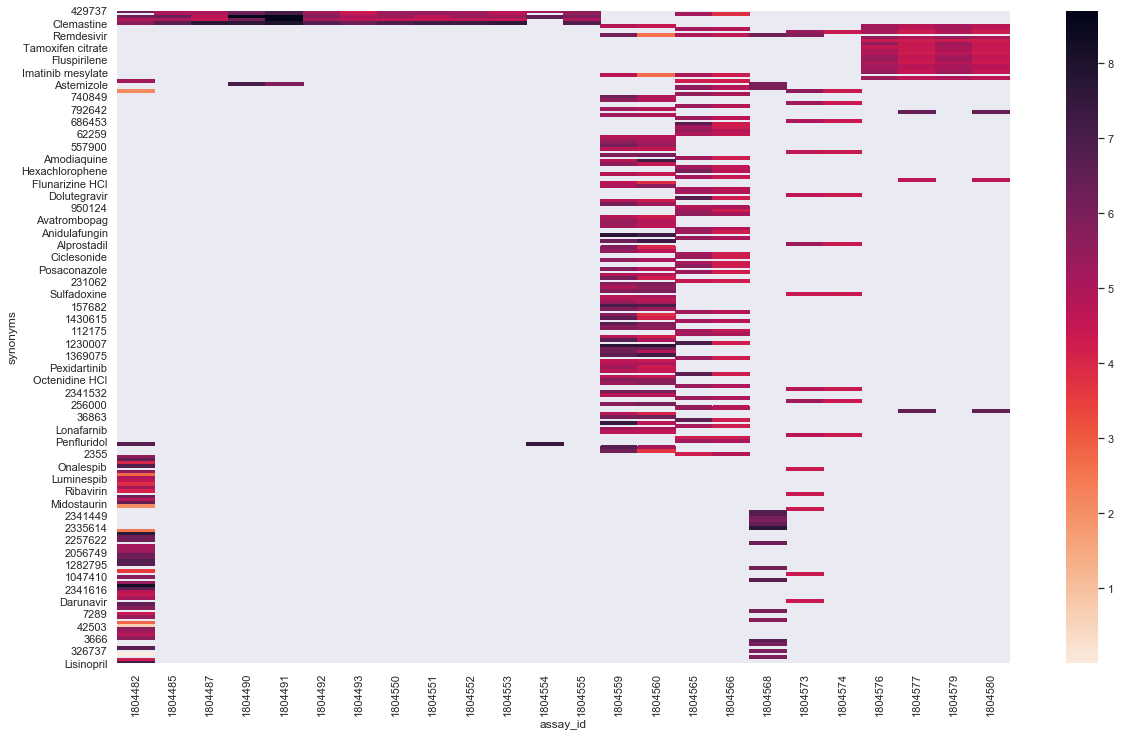

In [50]:
cmap = sns.cm.rocket_r
sns.set(rc={'figure.figsize': (20, 12)})
sns.heatmap(pivot_df,cmap=cmap)

In [51]:
top = df.molregno.isin(pivot_df.index[:10])
MolsToGridImage([Chem.MolFromSmiles(x) for x in df[top].canonical_smiles.unique()],molsPerRow=5,useSVG=True)

In [52]:
cols = pivot_df.shape[1]
id_list = list(pivot_df.index[:10])
id_df = df.query(f"molregno in {id_list}").drop_duplicates("molregno").copy()
id_df.synonyms.fillna(id_df.molregno,inplace=True)
id_df.synonyms = id_df.synonyms.astype(str)
num_assays = cols-pivot_df.isna().sum(axis=1)
names = [f"{x} {y}" for x,y in zip(id_df.synonyms,num_assays)]
MolsToGridImage([Chem.MolFromSmiles(x) for x in id_df.canonical_smiles],molsPerRow=5,legends=names,useSVG=True)

In [53]:
cols = pivot_df.shape[1]
cols - pivot_df.isnull().sum(axis=1)

synonyms
429737           13
Chloroquine      13
80081            13
2228183          12
Clemastine       12
                 ..
275631            1
242691            1
2341617           1
Lisinopril        1
Valproic acid     1
Length: 214, dtype: int64

In [62]:
synonym_list = sorted(unique_df.synonyms.unique())

In [63]:
@interact(name=synonym_list)
def show_data(name):
    query_str = f"synonyms == '{name}'"
    return df_nM.query(query_str)

interactive(children=(Dropdown(description='name', options=('1033892', '1047410', '105299', '109185', '10989',…